In [17]:
from IPython.display import clear_output

In [18]:
# ! apt install tree
# ! pip install pytorch_lightning 
# ! pip install albumentations
# ! pip install skimage
# ! pip install torchvision
# ! pip install opencv-python
# clear_output()

In [1]:
import torch
import torchvision
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn
import torch.nn.functional as F
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
from torchvision.datasets import ImageFolder

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from math import floor, ceil
from sklearn.model_selection import train_test_split

import shutil
import requests
import functools
import pathlib
from pathlib import Path
import shutil
from tqdm.notebook import tqdm
import os
from collections import defaultdict


matplotlib.rcParams['figure.figsize'] = (20, 5)

In [ ]:
# Alternative
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs

In [ ]:
! killall tensorboard

tensorboard: no process found


In [2]:
url = "https://fall.cv-gml.ru/task_file/14/public_tests"
file = "data.zip"

In [3]:
import requests

cookies = {
    'session': '.eJwlzjFqBDEMheG7uE5hyRpL2ssMkiWREEhgZrcKuXsMaV7xF4_vp5115f3eHs_rlW_t_Ij2aEAqc4g5kpoYRXiVTZjkHQ8HSQCNKNY8AA6ChZCdhkvmjOo6iWzWRNeOVkBRAxAVBhKWwjJnFkQZonsnrN55qSIMc_dqG_K68_rXINMO677qfH5_5tdOWyQMuiEpixlGZzXwfXIQZfTkERAz2u8fxcI-Xg.Y1z7MA.IlLtKJ5SwECajQaH8UOrgYzg1GU',
}

headers = {
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
    'Accept-Language': 'ru,en;q=0.9',
    'Cache-Control': 'max-age=0',
    'Connection': 'keep-alive',
    # 'Cookie': 'session=.eJwlzjFqBDEMheG7uE5hyRpL2ssMkiWREEhgZrcKuXsMaV7xF4_vp5115f3eHs_rlW_t_Ij2aEAqc4g5kpoYRXiVTZjkHQ8HSQCNKNY8AA6ChZCdhkvmjOo6iWzWRNeOVkBRAxAVBhKWwjJnFkQZonsnrN55qSIMc_dqG_K68_rXINMO677qfH5_5tdOWyQMuiEpixlGZzXwfXIQZfTkERAz2u8fxcI-Xg.Y1z7MA.IlLtKJ5SwECajQaH8UOrgYzg1GU',
    'Referer': 'https://fall.cv-gml.ru/login',
    'Sec-Fetch-Dest': 'document',
    'Sec-Fetch-Mode': 'navigate',
    'Sec-Fetch-Site': 'same-origin',
    'Sec-Fetch-User': '?1',
    'Upgrade-Insecure-Requests': '1',
    'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/102.0.5005.167 YaBrowser/22.7.5.933 Yowser/2.5 Safari/537.36',
    'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="102", "Yandex";v="22"',
    'sec-ch-ua-mobile': '?0',
    'sec-ch-ua-platform': '"Linux"',
}

response = requests.get('https://fall.cv-gml.ru/course/35/info', cookies=cookies, headers=headers)

In [4]:
def download(url, filename, **kwargs):    
    r = requests.get(url, **kwargs, stream=True, allow_redirects=True)
    if r.status_code != 200:
        r.raise_for_status()  # Will only raise for 4xx codes, so...
        raise RuntimeError(f"Request to {url} returned status code {r.status_code}")
    file_size = int(r.headers.get('Content-Length', 0))

    path = pathlib.Path(filename).expanduser().resolve()
    path.parent.mkdir(parents=True, exist_ok=True)

    desc = "(Unknown total file size)" if file_size == 0 else ""
    r.raw.read = functools.partial(r.raw.read, decode_content=True)  # Decompress if needed
    with tqdm.wrapattr(r.raw, "read", total=file_size, desc=desc) as r_raw:
        with path.open("wb") as f:
            shutil.copyfileobj(r_raw, f)

    return path

In [5]:
download(url, file, cookies=cookies, headers=headers)

  0%|          | 0/476554796 [00:00<?, ?it/s]

PosixPath('/home/alexkkir/cv-hw3-birds/data.zip')

In [ ]:
shutil.unpack_archive('data.zip', 'public_tests')

In [2]:
DATA_ROOT = Path('/mnt/ssd1/alexkkir/birds')
images_path = DATA_ROOT / '00_test_img_input' / 'train' / 'images'
labels_path = DATA_ROOT / '00_test_img_input' / 'train' / 'gt.csv'

In [ ]:
image_paths = [images_path / file for file in os.listdir(images_path)]

In [ ]:
sizes = defaultdict(int)
for imagepath in image_paths[:100]:
    image = plt.imread(imagepath)
    sizes[image.shape] += 1

50 классов по 50 изображения в каждом

In [ ]:
def modify_dataset_structure():
    data = pd.read_csv(labels_path)
    new_dataroot = DATA_ROOT / 'data'
    labels = data.class_id.unique()
    for label in labels:
        folder = new_dataroot / str(label)
        os.makedirs(folder, exist_ok=True)
    for index, row in tqdm(data.iterrows()):
        shutil.move(str(images_path / row.filename), str(new_dataroot / str(row.class_id)))

modify_dataset_structure()

0it [00:00, ?it/s]

In [3]:
class MyImageFolder(ImageFolder):
    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = np.array(sample)
            sample = self.transform(image=sample)['image']

        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

In [4]:
MEAN = np.array([0.485, 0.456, 0.406])
STD = np.array([0.229, 0.224, 0.225])


transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.3),
    A.Rotate(p=0.35, limit=15),
    A.RingingOvershoot(p=0.2, blur_limit=(3, 7)),
    A.OneOf([
        A.HueSaturationValue(p=0.5),
        A.RGBShift(p=0.3),
        A.Compose([ 
            A.RandomBrightnessContrast(p=0.5),
            A.RandomGamma(p=0.5),
            A.CLAHE(p=0.5),
        ], p=1)
    ], p=0.5),
    A.Affine(scale=(0.85, 1), translate_percent=(0, 0.10), shear=(-4, 4), p=0.35),
    A.Normalize(MEAN, STD),
    ToTensorV2(),
])

dataset = MyImageFolder(DATA_ROOT / 'data', transform=transform)
targets = dataset.targets

train_idx, valid_idx= train_test_split(
    np.arange(len(targets)),
    test_size=0.2,
    shuffle=True,
    stratify=targets
)

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

batch_size = 16
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=16)
valid_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=16)

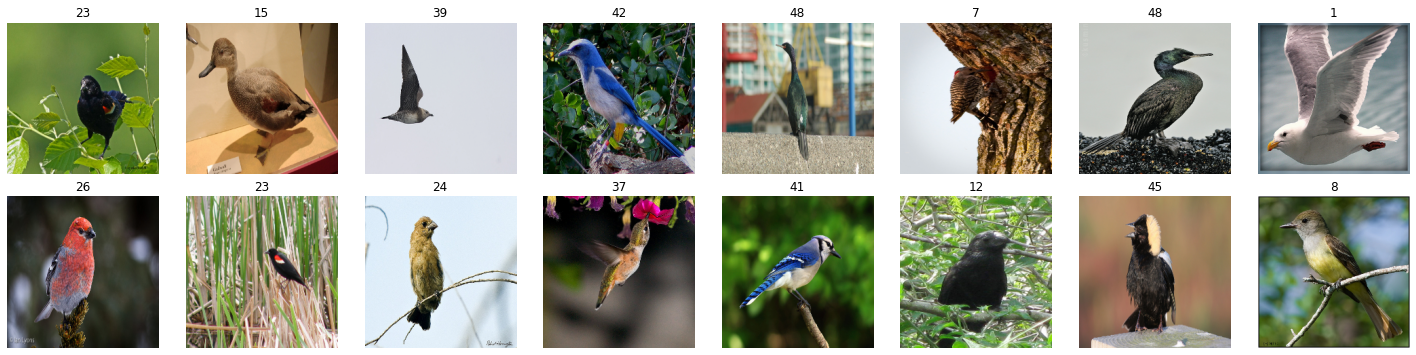

In [5]:
def display_batch(batch, cols=8):
    rows = ceil(len(batch[0]) / cols)
    fig_size = matplotlib.rcParams['figure.figsize'][0] / cols
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize = (fig_size * cols, fig_size * rows))
    for i, image in enumerate(batch[0]):
        image = image.permute(1, 2, 0)
        image = image * STD + MEAN
        predicted_label = int(batch[1][i])
        # color = "green" if true_label == predicted_label else "red"
        color = 'black'
        ax.ravel()[i].imshow((image * 255).type(torch.uint8))
        ax.ravel()[i].set_title(predicted_label, color=color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

display_batch(next(iter(train_loader)))

In [6]:
class Model(pl.LightningModule):
    def __init__(self):
        super().__init__()

        features = list(torchvision.models.resnet152(pretrained=True).children())[:-2]
        features = nn.Sequential(*features)
        for param in features.parameters():
            param.requires_grad = False
        self.features = features
        
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(2048, 50),
        )

        self.loss = nn.CrossEntropyLoss()
        self.acc = lambda pred, y: torch.sum(F.softmax(pred, dim=1).argmax(dim=1) == y) / y.shape[0]

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx):
        """the full training loop"""
        x, y = batch[0], batch[1]

        pred = self(x)
        loss = self.loss(pred, y)
        
        acc = self.acc(pred, y)

        return {'loss': loss, 'acc': acc}

    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=5e-4)

        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='max', 
            factor=0.2, 
            patience=5, 
            verbose=True)
        
        lr_dict = {
            # REQUIRED: The scheduler instance
            "scheduler": lr_scheduler,
            # The unit of the scheduler's step size, could also be 'step'.
            # 'epoch' updates the scheduler on epoch end whereas 'step'
            # updates it after a optimizer update.
            "interval": "epoch",
            # How many epochs/steps should pass between calls to
            # `scheduler.step()`. 1 corresponds to updating the learning
            # rate after every epoch/step.
            "frequency": 1,
            # Metric to monitor for schedulers like `ReduceLROnPlateau`
            "monitor": "val_acc"
        } 

        return [optimizer], [lr_dict]

    # OPTIONAL
    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        x, y = batch[0], batch[1]
        pred = self(x)
        loss = self.loss(pred, y)
        acc = self.acc(pred, y)

        return {'val_loss': loss, 'val_acc': acc}

    # OPTIONAL
    def training_epoch_end(self, outputs):
        """log and display average train loss and accuracy across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()

        print(f"| Train_acc: {avg_acc:.2f}, Train_loss: {avg_loss:.2f}" )

        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)

    # OPTIONAL
    def validation_epoch_end(self, outputs):
        """log and display average val loss and accuracy"""
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()

        print(f"[Epoch {self.trainer.current_epoch:3}] Val_acc: {avg_acc:.2f}, Val_loss: {avg_loss:.2f}", end= " ")

        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)

In [7]:
MyModelCheckpoint = ModelCheckpoint(dirpath='runs/pl_classifier',
                                    filename='{epoch}-{val_loss:.3f}',
                                    monitor='val_acc', 
                                    mode='max', 
                                    save_top_k=1)

MyEarlyStopping = EarlyStopping(monitor = "val_acc",
                                mode = "max",
                                patience = 10,
                                verbose = True)

trainer = pl.Trainer(
    max_epochs=100,
    # gpus=1,
    accelerator='gpu',
    devices=[0],
    callbacks=[MyEarlyStopping, MyModelCheckpoint],
    log_every_n_steps=1
)

model = Model()

trainer.fit(model, train_loader, valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alexkkir/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/alexkkir/anaconda3/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/alexkkir/anaconda3/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:601: UserWarning: Checkpoint directory /home/alexkkir/cv-hw3-birds/runs/pl_classifier exists and

Sanity Checking: 0it [00:00, ?it/s]

[Epoch   0] Val_acc: 0.06, Val_loss: 3.95 

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_acc improved. New best score: 0.607


[Epoch   0] Val_acc: 0.61, Val_loss: 1.51 | Train_acc: 0.33, Train_loss: 2.74


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.047 >= min_delta = 0.0. New best score: 0.654


[Epoch   1] Val_acc: 0.65, Val_loss: 1.07 | Train_acc: 0.66, Train_loss: 1.30


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.055 >= min_delta = 0.0. New best score: 0.709


[Epoch   2] Val_acc: 0.71, Val_loss: 0.91 | Train_acc: 0.76, Train_loss: 0.93


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.043 >= min_delta = 0.0. New best score: 0.752


[Epoch   3] Val_acc: 0.75, Val_loss: 0.79 | Train_acc: 0.79, Train_loss: 0.73


Validation: 0it [00:00, ?it/s]

Metric val_acc improved by 0.016 >= min_delta = 0.0. New best score: 0.768


[Epoch   4] Val_acc: 0.77, Val_loss: 0.75 | Train_acc: 0.84, Train_loss: 0.59


/home/alexkkir/anaconda3/lib/python3.8/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
